<a href="https://colab.research.google.com/github/Navyasri0922/AMS/blob/main/Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install pyspark
!pip3 install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


spark

In [3]:
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark UI available at: http://b7ca8eb5484a:4040


In [4]:
spark.sparkContext.setLogLevel("INFO")

In [5]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 94.4%
Memory Usage: 12.5%


In [6]:
# Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the data from a CSV file
df = spark.read.csv("/content/property (1).csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print("Total Records",df.count())
print("Total Partitions ",df.rdd.getNumPartitions())

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
|          3944|           6|            2|      1938|    3542| 845638.1354384426|
|          3671|           2|            1|      1963|    5105| 748779.2192281872|
|          3419|           4|            2|      1925|    5448| 743007.2614135538|
|           630|           2|            2|      2012|    3204| 135656.4528785377|
|   

In [9]:
# show Schema,Prints the structure of the dataset
df.printSchema()

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)



In [10]:
#Statistical Analysis
df.describe().show()

+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|summary|   Square_Footage|     Num_Bedrooms|     Num_Bathrooms|       Year_Built|         Lot_Size|             Price|
+-------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+
|  count|          1000000|          1000000|           1000000|          1000000|          1000000|           1000000|
|   mean|      2750.657104|         3.501114|          2.500439|       1960.52736|      5502.373911| 581839.6653163614|
| stddev|1298.569362387213|1.708173784151257|1.1178528780094728|35.21780350510348|2598.885882999355|260685.36722644986|
|    min|              500|                1|                 1|             1900|             1000| 51495.71116919513|
|    max|             4999|                6|                 4|             2021|             9999|1123219.4691521737|
+-------+-----------------+-------------

In [11]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 55.0%
Memory Usage after csv file: 16.1%


In [12]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c))
.alias(c) for c in df.columns]).show()

+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [13]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms","Lot_Size"],
                           outputCol = "Features")

In [14]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")

In [15]:
#create linear regression model.
regressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features'
                             )

In [16]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 47.0%
Memory Usage after csv file: 16.0%


In [17]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LRsaved_model")

In [18]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 56.7%
Memory Usage after csv file: 16.0%


In [19]:
#Loading the Pipeline

pipelineModel = Pipeline.load('./pipeline_LRsaved_model')

In [20]:
data_train , data_test = df.randomSplit([0.7,0.3], seed = 123)

In [21]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 52.6%
Memory Usage after csv file: 16.7%


In [22]:
Model = pipeline.fit(data_train)

In [23]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 93.5%
Memory Usage after csv file: 18.3%


In [24]:
print("total LR cofficents",len(Model.stages[2].coefficients) )
print("Cofficientents",Model.stages[2].coefficients)
print("Intecept",Model.stages[2].intercept)

total LR cofficents 4
Cofficientents [259711.00486894677,8489.99514668705,3381.1706206494705,258.3726928101678]
Intecept 6183.794632154185


In [25]:
#n the prediction phase, we test our model on some unseen data.
pred = Model.transform(data_test)
pred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|114478.16964496174|117632.63219959654|
|114555.32296890616|106670.25438504865|
|118174.56539497321|117919.45375887671|
|117853.72289965287|119893.50473253023|
|120390.33318083515|115218.14440379351|
|123967.41966701507|142918.60554292126|
|120123.70404966103|95443.54011673816 |
|119542.96620796097|75029.23686169085 |
|122883.32322982179|128827.18170769783|
|125796.2548140061 |131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [26]:
#create linear regression model.
Lasoregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [27]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 92.8%
Memory Usage after csv file: 19.3%


In [28]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|114478.71936215015|117632.63219959654|
|114555.84295354468|106670.25438504865|
|118174.76706989833|117919.45375887671|
|117854.04821753985|119893.50473253023|
|120390.75740258534|115218.14440379351|
|123967.54182467185|142918.60554292126|
|120123.9356246857 |95443.54011673816 |
|119543.42158172758|75029.23686169085 |
|122883.5677678471 |128827.18170769783|
|125796.45323308372|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [29]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)

In [30]:
#n the prediction phase, we test our model on some unseen data.
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|114478.34826509983|117632.63219959654|
|114555.50164268001|106670.25438504865|
|118174.74343768165|117919.45375887671|
|117853.90071931662|119893.50473253023|
|120390.50961680447|115218.14440379351|
|123967.5954426128 |142918.60554292126|
|120123.88129193537|95443.54011673816 |
|119543.14304651541|75029.23686169085 |
|122883.49924343401|128827.18170769783|
|125796.42970553659|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [31]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol =
                                    'Price',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(pred)
mselasso = evaluator_mse.evaluate(lassopred)
mseridge = evaluator_mse.evaluate(Ridgepred)

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'Price',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'Price',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge)

Regression - MSE:  410447639.3564562 , RMSE:  20259.507381880147 , R^2:  0.9939608913793314
Lasso - MSE:  410447658.7494203 , RMSE:  20259.507860494054 , R^2:  0.9939608910939937
Ridge - MSE:  410447639.1337195 , RMSE:  20259.50737638306 , R^2:  0.9939608913826087


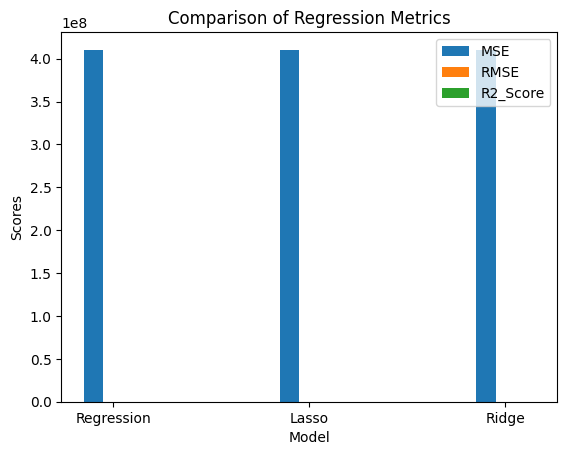

In [32]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.1

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()